In [10]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import torch.distributions as dist


In [11]:
# Load California Housing Dataset
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target
scaler = StandardScaler()
y = scaler.fit_transform(y.reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
class NAMLSS(nn.Module):
    def __init__(self, input_dim):
        super(NAMLSS, self).__init__()
        self.fc_all = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1, 256), 
                nn.ReLU(),     
                nn.Linear(256, 128),
                nn.Tanh(),
                nn.Linear(128, 2)   # Output 2 neurons (mean and variance)
            ) for _ in range(input_dim)
        ])

    def forward(self, x):
        vals = [self.fc_all[i](x[:, i:i+1]) for i in range(x.shape[1])]
        x = torch.stack(vals, dim=1)
        means = x[:, :, 0]
        vars = nn.Softplus()(x[:, :, 1])   # ensure that each var is positive, add small constant to ensure positivity
        outputs = torch.sum(means, dim=1).unsqueeze(dim=1)  # theoretically, you can use feature dropout here
        vars_sum = torch.sum(vars, dim=1).unsqueeze(dim=1) + 1e-06
        return outputs, vars_sum

    def plotting_preds(self, x):
        vals = [self.fc_all[i](x[:, i:i+1]) for i in range(x.shape[1])]
        x = torch.stack(vals, dim=1)
        means = x[:, :, 0]  # Extract the mean values
        return means.detach().cpu().numpy()

# Negative log-likelihood loss function for normal distribution
def nll_loss(mean, variance, y_true):
    # Calculate the negative log-likelihood using variance
    normal_dist = dist.Normal(mean, variance)

    nll = -normal_dist.log_prob(y_true).mean()

    return nll

In [13]:
# Check for GPU availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate and train the model
input_dim = X_train_scaled.shape[1]
model = NAMLSS(input_dim).to(device)  # Move the model to the device
optimizer = optim.Adam(model.parameters(), lr=1e-04)

# Move data to device
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)


# Create a dataset and dataloader for mini-batch training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)



In [14]:

num_epochs = 100
progress_bar = tqdm(range(num_epochs), desc="Training")

for epoch in progress_bar:
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move batch data to the device

        optimizer.zero_grad()
        outputs, log_vars = model(X_batch)
        loss = nll_loss(outputs, log_vars, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate the average loss for this epoch
    avg_loss = running_loss / len(train_loader)

    # Update the progress bar postfix with the current loss
    progress_bar.set_postfix({"Loss": f"{avg_loss:.4f}"})

# Predictions
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)


Training: 100%|██████████| 100/100 [02:48<00:00,  1.68s/it, Loss=0.5974]


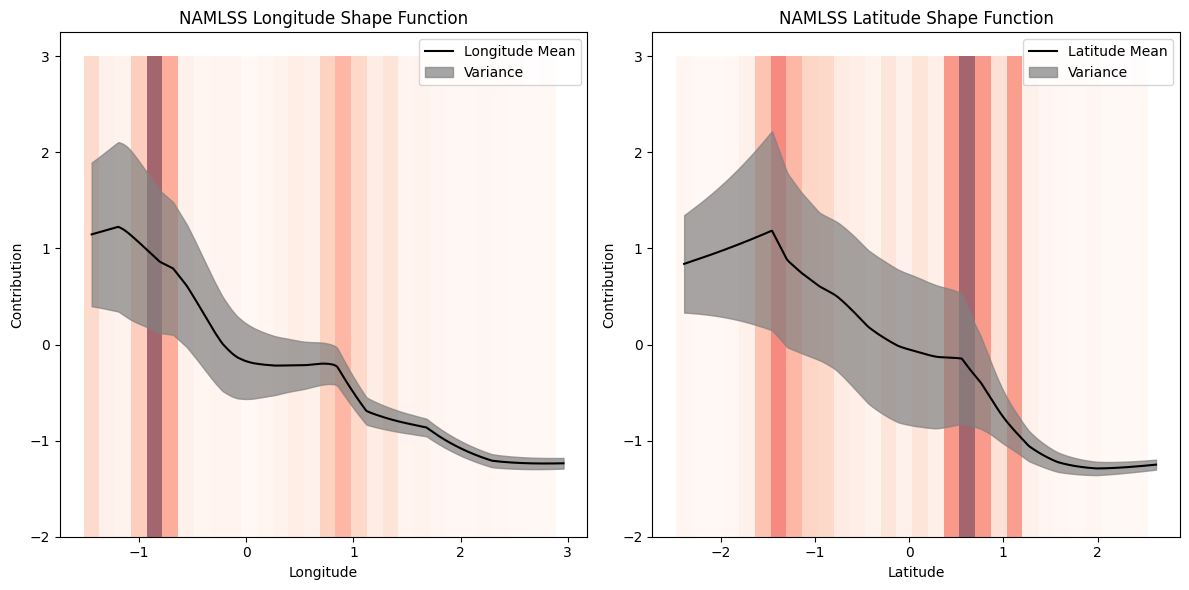

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Check for GPU availability and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate range for longitude and latitude
longitude_range = np.linspace(X_train_scaled[:, 6].min(), X_train_scaled[:, 6].max(), 500).reshape(-1, 1)
latitude_range = np.linspace(X_train_scaled[:, 7].min(), X_train_scaled[:, 7].max(), 500).reshape(-1, 1)

# Convert the range to tensor and move it to the device for the model
longitude_tensor = torch.tensor(longitude_range, dtype=torch.float32).to(device)
latitude_tensor = torch.tensor(latitude_range, dtype=torch.float32).to(device)

# Set the model to evaluation mode and move the model to the device
model.eval()
nam = model.to(device)

# Get the mean and variance for longitude
longitude_outputs = nam.fc_all[6](longitude_tensor)
longitude_means = longitude_outputs[:, 0].detach().cpu().numpy().flatten()
longitude_vars = nn.Softplus()(longitude_outputs[:, 1]).detach().cpu().numpy().flatten()

# Calculate standard deviation from variance
longitude_stds = np.sqrt(longitude_vars)

# Get the mean and variance for latitude
latitude_outputs = nam.fc_all[7](latitude_tensor)
latitude_means = latitude_outputs[:, 0].detach().cpu().numpy().flatten()
latitude_vars = nn.Softplus()(latitude_outputs[:, 1]).detach().cpu().numpy().flatten()

# Calculate standard deviation from variance
latitude_stds = np.sqrt(latitude_vars)

# Compute the upper and lower confidence bands (+/- 1.96 std)
longitude_upper = longitude_means + 1.96 * longitude_stds
longitude_lower = longitude_means - 1.96 * longitude_stds
latitude_upper = latitude_means + 1.96 * latitude_stds
latitude_lower = latitude_means - 1.96 * latitude_stds

# Shift the y range for better visualization (optional)
y_train_shifted = y_train  # Adjust this if needed for your data

# Longitude plot
plt.figure(figsize=(12, 6))

# Longitude subplot
plt.subplot(1, 2, 1)
# Create the bins and calculate the counts for each bin
num_bins = 30
counts, bin_edges = np.histogram(X_train_scaled[:, 6], bins=num_bins)
# Normalize the counts to range [0, 1] for coloring
norm_counts = counts / counts.max()

# Create vertical colored bars with color intensity based on density
for i in range(num_bins):
    plt.bar(bin_edges[i], height=5, bottom=-2, width=bin_edges[i+1] - bin_edges[i], color=plt.cm.Reds(norm_counts[i]), alpha=0.6)

# Plot mean and confidence intervals
plt.plot(longitude_range, longitude_means, color='black', label='Longitude Mean')
plt.fill_between(longitude_range.flatten(), longitude_lower, longitude_upper, color='gray', alpha=0.7, label='Variance')
plt.title('NAMLSS Longitude Shape Function')
plt.xlabel('Longitude')
plt.ylabel('Contribution')
plt.legend()

# Latitude subplot
plt.subplot(1, 2, 2)
# Create the bins and calculate the counts for each bin
counts, bin_edges = np.histogram(X_train_scaled[:, 7], bins=num_bins)
# Normalize the counts to range [0, 1] for coloring
norm_counts = counts / counts.max()

# Create vertical colored bars with color intensity based on density
for i in range(num_bins):
    plt.bar(bin_edges[i], height=5, bottom=-2, width=bin_edges[i+1] - bin_edges[i], color=plt.cm.Reds(norm_counts[i]), alpha=0.6)

# Plot mean and confidence intervals
plt.plot(latitude_range, latitude_means, color='black', label='Latitude Mean')
plt.fill_between(latitude_range.flatten(), latitude_lower, latitude_upper, color='gray', alpha=0.7, label='Variance')
plt.title('NAMLSS Latitude Shape Function')
plt.xlabel('Latitude')
plt.ylabel('Contribution')
plt.legend()

plt.tight_layout()
plt.show()
